In [1]:
import os
import sys

In [2]:
sys.path.insert(0, '/data/yinjyun/projects/constant-memory-waveglow/')

In [3]:
import numpy as np
import torch
import model.model as module_arch
from utils.util import remove_weight_norms
from train import get_instance
from librosa import load
from librosa.output import write_wav
from time import time
import json
from IPython.display import Audio, display
import matplotlib.pyplot as plt

In [156]:
resume = '/data/yinjyun/projects/constant-memory-waveglow/saved/MusicGlow/0527_131745/checkpoint-step200000.pth'
config = torch.load(resume)['config']

In [157]:
model = get_instance(module_arch, 'arch', config)
model.summary()
checkpoint = torch.load(resume)
state_dict = checkpoint['state_dict']
if config['n_gpu'] > 1:
    model = torch.nn.DataParallel(model)
model.load_state_dict(state_dict)

if config['n_gpu'] > 1:
    model = model.module
model.apply(remove_weight_norms)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

Trainable parameters: 92202168
WaveGlow(
  (invconv1x1): ModuleList(
    (0): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (1): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (2): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (3): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (4): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (5): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (6): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (7): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (8): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (9): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (10): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (11): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (12): Inverti

WaveGlow(
  (invconv1x1): ModuleList(
    (0): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (1): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (2): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (3): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (4): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (5): InvertibleConv1x1(8, 8, kernel_size=(1,), stride=(1,), bias=False)
    (6): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (7): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (8): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (9): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (10): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (11): InvertibleConv1x1(6, 6, kernel_size=(1,), stride=(1,), bias=False)
    (12): InvertibleConv1x1(4, 4, kernel_size=(1

In [158]:
dur = 20
sr = config['arch']['args']['sr']

In [159]:
config['arch']['args']

{'flows': 18,
 'n_group': 8,
 'n_early_every': 6,
 'n_early_size': 2,
 'sr': 16000,
 'window_size': 2048,
 'hop_size': 512,
 'n_mels': 80,
 'dilation_channels': 256,
 'residual_channels': 256,
 'skip_channels': 256,
 'depth': 8,
 'radix': 3,
 'bias': False,
 'memory_efficient': True}

In [ ]:
def inference(infile):
    y, _ = load(infile, sr=sr, duration=dur)
    print(infile)
    display(Audio(y, rate=sr))
    y = torch.Tensor(y).to(device)
    mel = model.get_mel(y[None, :])
    print(mel.shape)
    print(torch.max(mel), torch.min(mel))
    x = model.infer(mel, sigma=1.0)
    mel_hat = model.get_mel(x[None, :])
    display(Audio(x.cpu().float().numpy(), rate=sr))
    plt.close()
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(mel.squeeze(0).cpu().detach(), aspect='auto', origin='lower')
    ax[1].imshow(mel_hat.squeeze(0).cpu().detach(), aspect='auto', origin='lower')
    plt.show()

In [160]:
metadata = json.load(open(os.path.join('/data/yinjyun/datasets/', 'maestro-v2.0.0.json')))
train_files = sorted([os.path.join('/data/yinjyun/datasets/maestro/', row['audio_filename']) 
                      for row in metadata if row['split'] == 'train'])
test_files = sorted([os.path.join('/data/yinjyun/datasets/maestro/', row['audio_filename']) 
                      for row in metadata if row['split'] == 'test'])
n_sample = 5
np.random.seed(1234)
idx_train = np.random.choice(len(train_files), n_sample, replace=False)
idx_test = np.random.choice(len(test_files), n_sample, replace=False)

In [187]:
infile = torch.Tensor(np.load("temp_4.npy")).cuda()
melspec = torch.cat([infile.squeeze(), torch.zeros(80).cuda().unsqueeze(-1)], dim=-1).detach()
print(melspec.shape)
print(torch.max(melspec), torch.min(melspec))

torch.Size([80, 626])
tensor(5.4449, device='cuda:0') tensor(-12.0923, device='cuda:0')


torch.Size([304512])


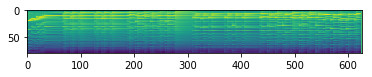

In [188]:
melspec_temp = melspec * 1.5
x = model.infer(melspec_temp.unsqueeze(0), sigma=0.5)
x = x[:-16000]
print(x.shape)
plt.imshow(melspec.cpu().detach().numpy().squeeze())
plt.show()

In [177]:
# 1
Audio(x.cpu().float().numpy(), rate=sr)

In [183]:
# 2
Audio(x.cpu().float().numpy(), rate=sr)

In [186]:
# 3
Audio(x.cpu().float().numpy(), rate=sr)

In [189]:
# 4
Audio(x.cpu().float().numpy(), rate=sr)

In [ ]:
print("Audios from the training set")
for i in range(n_sample):
    inference(train_files[idx_train[i]])
print("Audios from the testing set")
for j in range(n_sample):
    inference(test_files[idx_test[j]])

In [ ]:
!pip install noisereduce